In [18]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2
import time
import os
import csv

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.widgets import Button
import matplotlib.font_manager as fm
from scipy import constants
from scipy import stats
from epsd_peakfinder_exp2 import epsd_peakfinder
from ne_from_scpot import fit_ne
from plot_fpe_peak_fitting import plot_ne_vsc_spectra
from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, plot_spectr, use_pyrfu_style, plot_surf
mms.db_init(default="local", local="../../../data/mms")




[18-Mar-25 10:19:34] INFO: Updating MMS data access configuration in /homelocal/atlass/.venv/lib/python3.12/site-packages/pyrfu/mms/config.json...
[18-Mar-25 10:19:34] INFO: Updating MMS SDC credentials in /homelocal/atlass/.config/python_keyring...


[18-Mar-25 10:31:54] INFO: Loading mms1_aspoc_ionc...
[18-Mar-25 10:31:54] INFO: Loading mms1_edp_scpot_fast_l2...


Found 1516 valid solar wind tints of length > 1 hours.
OUT: 1/1516, ['2024-05-03T16:25:37', '2024-05-04T08:29:10']
	CHECKING ASPOC...
	ASPOC = ON INTERVAL FOUND: cutting tint from ['2024-05-03T16:25:37', '2024-05-04T08:29:10'] to ['2024-05-03T16:25:37.000000000', '2024-05-04T08:14:04.000000000']


[18-Mar-25 10:31:54] INFO: Loading mms1_dsp_epsd_omni...


Intervals of missing data not found
Running peakfinder on tint: ['2024-05-03T16:37:14.234309180', '2024-05-04T08:14:03.995068504'] of length 15.613822433145556
1: Initial peakfinder


[18-Mar-25 10:31:56] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

[18-Mar-25 10:31:56] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

[18-Mar-25 10:31:56] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

[18-Mar-25 10:31:56] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



	21725 PEAKS FOUND
		FMAX =  30905.19801156593
2: Initial fit to obtain plasma line template
	Resampling SCpot to peaks
COEFFS [ 0.57275765 -0.67069335  0.01699354  0.0956722 ]
	METHOD 3
	Using mean of Vsc to fit, BETA: 2.4637416533852816
	3 BETA: 2.4637416533852816
++++++++++++++++++++ 2.4637416533852816 42.86846715392716
	TEMPLATE OBTAINED WITH (N, beta) = (42.86846715392716, 2.4637416533852816) 
	USING NEAREST POINTS: Cannot guess sampling frequency. Tried 10 times
	USING NEAREST POINTS: Cannot guess sampling frequency. Tried 10 times
3: Obtaining improved peaks using template...
LARGE VARIANCE OF SCPOT
	USING NEAREST POINTS: Cannot guess sampling frequency. Tried 10 times


[18-Mar-25 10:31:56] WARNING: /homelocal/atlass/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,



	BEST:	index	corr	frac	score
		2	0.911	0.806	0.64357
4: Second fitting with improved peaks...
COEFFS [ 0.57275765 -0.67069335  0.01699354  0.0956722 ]
	2 BETA: 2.872617829686757
BDIFF: 0.41870829148057354
5: Plotting...
6: Writing to output... 

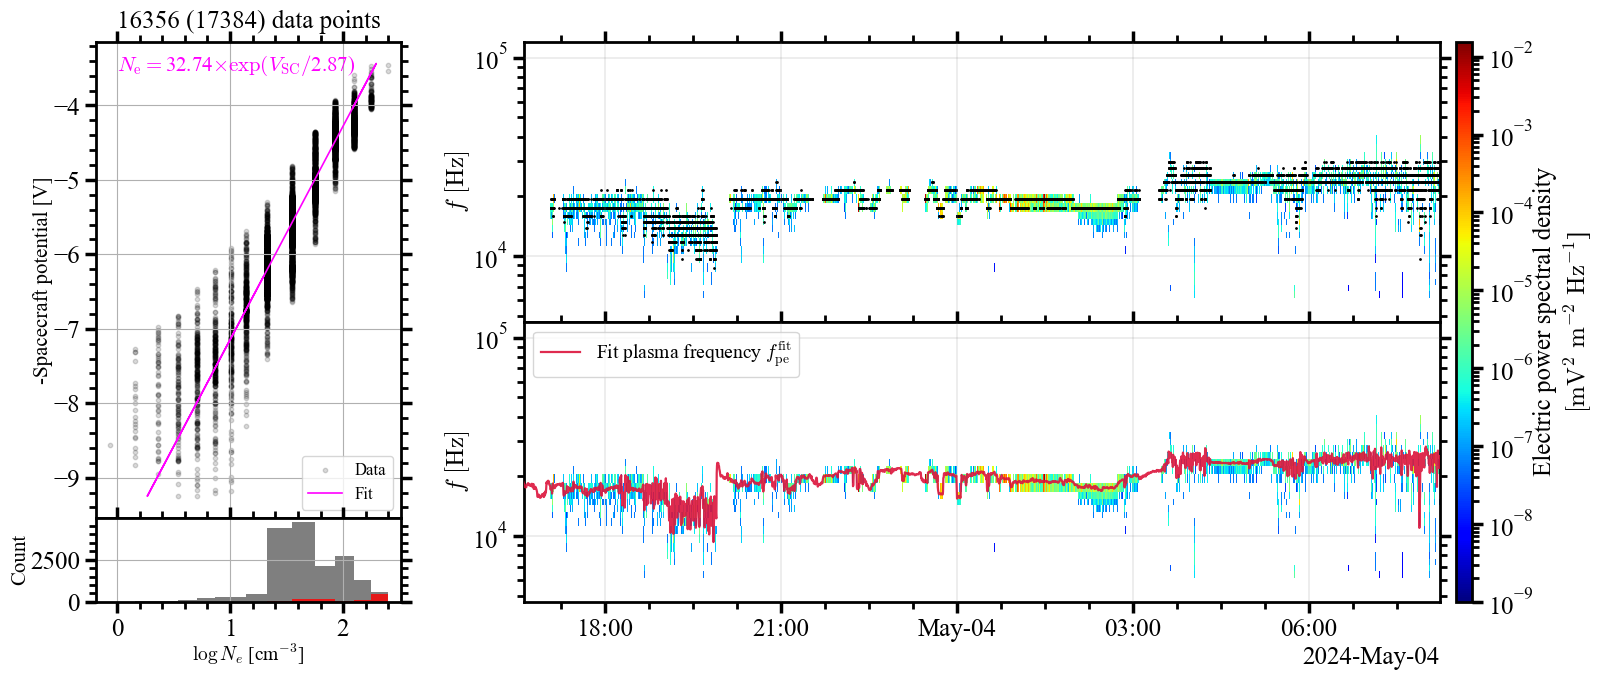

In [ ]:


def get_swtints(filepath, tint_minlength_minutes):
    # Load SW tints (each row is two strings: start and end times)
    sw_tints = np.genfromtxt(filepath, dtype=str)

    # Minimum tint length as timedelta
    tint_minlength_td = np.timedelta64(tint_minlength_minutes, 'm')


In [ ]:

    valid_swtints = []
    for tint in sw_tints:
        start, end = pyrf.iso86012datetime64(tint)
        duration = (end - start).astype('timedelta64[m]')
        tint_aslist = [str(start), str(end)]
        if duration >= tint_minlength_td and tint_aslist not in valid_swtints:
            valid_swtints.append(tint_aslist)  # Store as list of strings

    # Output results
    if valid_swtints:
        print(f"Found {len(valid_swtints)} valid solar wind tints of length > {tint_minlength_minutes // 60} hours.")
    else:
        print("No valid solar wind tints found.")
        
    return valid_swtints


def split_tint(time_series, tint_minlength_minutes):
    # Full time interval of input time series
    tint_orig = [str(time_series.time.data[0]), str(time_series.time.data[-1])]
    # print((time_series.time.data[-1] - time_series.time.data[0]) / np.timedelta64(1, 'h'))
    
    # Identify gaps in timeseries data and cut up original tint into smaller tints containing only data
    diffs=np.diff(time_series.time)
    timegap_thresh = np.timedelta64(30,'s')
    jump_idxs = np.where(diffs >= timegap_thresh)[0]

    if len(jump_idxs) > 0:
        jump_idxs = np.insert(jump_idxs, 0, 0)
        jump_idxs = np.append(jump_idxs, -1)

        clip_intervals = []
        # Do not include last 
        for i in range(len(jump_idxs) - 1):
            start_idx, stop_idx = jump_idxs[i], jump_idxs[i+1]
            if i > 0 : start_idx += 1
            start, stop = time_series.time.data[start_idx], time_series.time.data[stop_idx]
            tint_len_ns = stop - start
            tint_len_minutes = tint_len_ns / np.timedelta64(1, 'm')
            if tint_len_minutes >= tint_minlength_minutes:               
                clip_tint = [str(start), str(stop)]
                clip_intervals.append(clip_tint)
                print('Created new sub-tint of, ',tint_len_minutes, 'mins.')
            else:
                print('Sub-tint not long enough', (tint_len_minutes), 'mins.')
    else:
        print('Intervals of missing data not found')
        clip_intervals = [tint_orig]
    
    return clip_intervals


def calculate_plasma_frequency(inp, inverse=False):
    """Convert number density in cc to plasma frequency or vice versa."""
    # Constants for plasma frequency calculation
    ep0 = constants.epsilon_0
    m_e = constants.electron_mass
    q_e = constants.elementary_charge
    if not inverse:  # ne (cc) -> ne (SI) -> f_pe
        return 1 / (2 * np.pi) * np.sqrt(inp * 1e6 * q_e**2 / (m_e * ep0))
    else:  # f_pe -> ne (SI -> ne (cc))
        w_pe_peaks = 2 * np.pi * inp
        n_e_peaks = w_pe_peaks**2 * ep0 * m_e / q_e**2
        return n_e_peaks * 1e-6  # Convert to cubic centimeters
    

def resample_to_peaks(data, target):
    """Resample data to match the time series of target peaks."""
    try:
        return pyrf.resample(data, target)
    except RuntimeError as e:
        print("\tUSING NEAREST POINTS:", e)
        return data.sel(time=target.time, method="nearest")
    
def refine_peaks_template(f_peaks_lo, fpe_full_rs, vsc_tofit, logne_peaks, frequency_bins, fmin, template_method=1):
    npeaks = len(f_peaks_lo)

    
    if template_method == 1:
        fstart = 1.5*fpe_full_rs
        # fmax = np.nanmedian(f_peaks_lo)
        fmax = np.nanmedian(fstart)
        frange = np.arange(0, fmax-fmin, 200)
       
    elif template_method == 2:            
        # MEDIAN
        f_med = f_peaks_lo.rolling(time=30).mean()
        fpe_full_rs = resample_to_peaks(f_med, f_peaks_lo)
        fstart = fpe_full_rs+5000
        fmax = np.nanmedian(fstart)
        frange = np.linspace(0, 10000, 5)
    
    
    scores, corrs, fracs = np.zeros(len(frange)), np.zeros(len(frange)), np.zeros(len(frange))
    lowers = np.zeros(len(frange), dtype=object)
    uppers = np.zeros(len(frange), dtype=object)
    weights = np.zeros(len(frange), dtype=object)
    best_score = 0
    
    # Estimate local bin width Δf for each peak (non-uniform)
    fbins =  frequency_bins 
    df = np.diff(fbins)

    df = np.append(df, df[-1])  # Keep last bin width same as the previous one

    f_peaks_valid_idxs = {}
    
    # Weights: 0.4 and 0.6 default
    # frac_w, corr_w = 0.7, 0.3
    k = 3.5  # 3.5
    corr_ws = [0.8, 0.7, 0.6, 0.5, 0.4, 0.2]
    frac_ws = [1-w for w in corr_ws]
    # print('\t\tindex\tcorr\tfrac\tscore')
    for i, freq in enumerate(frange):
        # f_template = fpe_full_rs - freq
        f_template = fstart - freq
        f_template_movstd = f_template.rolling(time=20, min_periods=1).std()
        
        # Define adaptive window (multiple of upper and lower std bounds)
        for k in np.linspace(1.5, 5, 20):
            upper_bound = f_template + k * f_template_movstd
            lower_bound = f_template - k * f_template_movstd
            
            # Prevent lower bound to go below 6400 Hz
            # lower_bound = np.where(lower_bound_.data >= 6400, lower_bound_.data, 6400)
            
            
            # Find the bin width at the same index as f_template
            nearest_df = np.interp(f_template.data, fbins, df)
            

            # Expand by half of the local bin width
            # lower_bound -= nearest_df / 2 
            upper_bound += 2*nearest_df 
            
        
            # Select indices within the adaptive window
            idxs = np.where((f_peaks_lo.data >= lower_bound.data) & (f_peaks_lo.data <= upper_bound.data))[0]
            
          
            
            frac = len(idxs) / npeaks
            # if frac < 0.05:
            #     print('Fraction of points too low')
            #     continue  # Skip if too few points
            if len(idxs) < 50:
                # print('\tToo few points in within template window!')
                continue
            # Compute Pearson correlation
            corr = stats.pearsonr(-vsc_tofit[idxs], logne_peaks[idxs])[0]
            freq_w = (np.median(f_peaks_lo[idxs].data) - 6400) / (fmax - 6400)
            # freq_w = 1
            for corr_w in corr_ws:
                frac_w = 1 - corr_w 
                # for frac_w in frac_ws:
                # Weighted scoring
                score = (frac_w * frac + corr_w * corr) * freq_w
                # score = corr
                if score >= best_score and frac >= 0.3 and corr >= 0.1: # ÄNDRA FRAC T 0.1?
                    best_idx = i
                    best_score = score
                    best_corr = corr
                    best_frac = frac
                    ws = [frac_w, corr_w]
                    best_k = k
                    best_f_peak_idxs = idxs
                    best_upper = upper_bound
                    best_lower = lower_bound
                    best_weights = 1 / (f_template_movstd[idxs] + 1e-6)
                    best_weights /= best_weights.sum()
                    # print(f'\t\t{best_idx}\t{best_corr:.3f}\t{best_frac:.3f}\t{best_score:.5f}\t{ws}\t{best_k}')

                        
    # Save best scoring peaks
    best_score_idx = best_idx
    corr = best_corr
    score = best_score
    frac = best_frac
    f_peaks_valid = f_peaks_lo[best_f_peak_idxs]
    upper_best = best_upper
    lower_best = best_lower
    weights_best = best_weights


    

    
    print(f'\tBEST:\tindex\tcorr\tfrac\tscore')
    print(f'\t\t{best_score_idx}\t{corr:.3f}\t{frac:.3f}\t{score:.5f}')
    return f_peaks_valid, upper_best, lower_best, best_score_idx, corr, frange, weights_best
    
def write_to_file(filepath, output):
    # Ensure file exists and write header if not present
    if not os.path.exists(filepath):
        output_header = [
        "start", "end", "pearsonr", "num_tot", 
        "num_outliers", "std_thresh", "N_fit", "beta_fit", 
        "N_err", "beta_err", "vsc_mean", "vsc_median", "vsc_var", "ic"
        ]
        with open(filepath, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(output_header)

    # Write results to file
    with open(filepath, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(output)
        
def write_to_cdf(filepath, ne_ts_data, time_axis, time_peaks_initial, time_peaks_final, out_params):
    """
    Save estimated number density data to a CDF file.
    """
    
    ds = xr.Dataset(
    {
        # Variables with main time axis
        "ne_ts_final": (["time"], ne_ts_data["ne_ts_final"]),
        "ne_std_upper": (["time"], ne_ts_data["ne_std_upper"]),
        "ne_std_lower": (["time"], ne_ts_data["ne_std_lower"]),
        "ne_peaks_upperlim": (["time"], ne_ts_data["ne_peaks_upperlim"]),
        "ne_peaks_lowerlim": (["time"], ne_ts_data["ne_peaks_lowerlim"]),
        
        # Variables with their own time axes
        "ne_peaks_initial": (["time_peaks_initial"], ne_ts_data["ne_peaks_initial"]),
        "ne_peaks_final": (["time_peaks_final"], ne_ts_data["ne_peaks_final"]),
    },
    coords={
        "time": time_axis,  # Main time axis
        "time_peaks_initial": time_peaks_initial,  # Separate time axis for peaks_initial
        "time_peaks_final": time_peaks_final,  # Separate time axis for peaks_final
    },
    attrs={
        "start": out_params["start"],
        "end": out_params["end"],
        "ne_points_fit": out_params["ne_points_fit"],
        "vsc_points_fit": out_params["vsc_points_fit"],
        "outlier_idxs": out_params["outlier_idxs"],
        "N0_fit": out_params["N0_fit2"],
        "beta_fit": out_params["beta_fit2"],
        "pearsonr": out_params["pearsonr"],
        "num_tot": out_params["num_tot"],
        "num_outliers": out_params["num_outliers"],
        "std_thresh": out_params["std_thresh"],
        "beta_err": out_params["beta_err"],
        "N_err": out_params["N_err"],
        "vsc_mean": out_params["vsc_mean"],
        "vsc_median": out_params["vsc_median"],
        "vsc_var": out_params["vsc_var"],
        "ic": out_params["ic"],
        "pw_threshold": out_params["pw_threshold"],
        "description": "Estimated plasma frequency time series with 99% confidence intervals",
        "units": "Hz",
    },
    )
    # Encoding to ensure compatibility with NetCDF3 (if needed)
    encoding = {
        "time": {"dtype": "float64", "units": "seconds since 1970-01-01"},
        "time_peaks_initial": {"dtype": "float64", "units": "seconds since 1970-01-01"},
        "time_peaks_final": {"dtype": "float64", "units": "seconds since 1970-01-01"},
    }
    ds.to_netcdf(filepath, encoding=encoding) 
    print(f'\t===> Written to: {filepath}')



def main(ic, tint_minlength_minutes = 8*60, mode: str = 'loop', single_tint = None, show_final_errorbars = False, debug_window = False, scatter_errorbars = False, pw_threshold = 1e-10):
    continue_from = 0
    swtints = get_swtints(f'sw_tints/mms{ic}_sw_tints.txt', tint_minlength_minutes)
    num_swtints = len(swtints)
    if mode == 'loop':
        tints_to_calc =swtints
        
    elif mode == 'random':
        # Pick random tint
        tints_to_calc = [swtints[np.random.randint(0, num_swtints+1)]]
    elif mode == 'single' and single_tint is not None:
        # tint = ['2024-04-05T13:26:03.858526000', '2024-04-06T05:08:30.000000000']
        # tint = ['2024-05-25T05:28:05', '2024-05-25T06:21:49']
        # tint = ['2018-01-07T05:28:00.000000000', '2018-01-08T03:08:31.989020500']
        # tint = ['2018-12-31T21:22:54.150444109','2019-01-01T00:24:04.273310525']
        # tint = ['2018-04-11T10:43:31', '2018-04-11T18:50:26']
        # tint = ['2018-02-17T15:42:03.837839000', '2018-02-17T20:18:10.000000000']
        tints_to_calc = [single_tint]
    else:
        raise ValueError('Invalid function arguments')
        
    
    for i, tint in enumerate(tints_to_calc[continue_from:]):
        print(f'OUT: {i+1+continue_from}/{num_swtints}, {tint}')
        
        print('\tCHECKING ASPOC...')
        aspoc = mms.get_data('ionc_aspoc_srvy_l2', tint, ic)
        times_aspoc_off = ((aspoc).where(aspoc < 5, drop=True)).time.data
        
        if len(times_aspoc_off) > 0:
            tint_aspoc_off = [str(times_aspoc_off[0]), str(times_aspoc_off[-1])]
            print(f'\tASPOC = ON INTERVAL FOUND: cutting tint from {tint} to {tint_aspoc_off}')
            tint = tint_aspoc_off
        else:
            print('\tNO INTERVALS WHERE ASPOC = ON WAS FOUND.')
        
        try:
            vsc_ = mms.get_data("v_edp_fast_l2", tint, ic)
        except FileNotFoundError:
            print('NO EDP DATA FOUND FOR TINT', tint, '--- SKIPPING!')
            continue
        vsc = vsc_.drop_duplicates(dim='time')

        if vsc.time.size > 0:
            clip_intervals = split_tint(vsc, tint_minlength_minutes)
        else:
            print('SPACECRAFT POTENTIAL EMPTY')
            continue
        
        # Fallback beta coefficients
        coeffs = np.genfromtxt('out2402_nofallback/beta_vsc_coeff_2402'+'.csv', delimiter=',', skip_header=0)
        coeffs = coeffs[ic, 1:]  

        figs = []
        # Main loop per tint - do analysis separately on each tint (if multiple)
        for tint_clip in clip_intervals:
            # Length of tint
            start_dt, end_dt = np.datetime64(tint_clip[0]), np.datetime64(tint_clip[-1])
            tint_clip_len = (end_dt - start_dt)/ np.timedelta64(1, 'h')
            print('Running peakfinder on tint:',tint_clip, 'of length', tint_clip_len)
            if tint_clip_len <= tint_minlength_minutes/60:
                print(tint_minlength_minutes/60)
                continue
            # Get new data for each clipped tint, skipping points where scpot does not have data
            epsd_ = mms.db_get_ts(f'mms{ic}_dsp_fast_l2_epsd',f'mms{ic}_dsp_epsd_omni', tint_clip)
            # try:
            #     n_e_fpi_ = mms.get_data("ne_fpi_fast_l2", tint_clip, ic)
            # except FileNotFoundError:
            #         print('NO FPI DATA FOUND FOR TINT', tint_clip, '--- SKIPPING!')
            #         continue
            # Drop duplicates
            epsd = epsd_.drop_duplicates(dim='time')
            # n_e_fpi = n_e_fpi_.drop_duplicates(dim='time')
            
            # Convert from V to mV
            epsd = epsd * 1e3

            # Clip full time series of scpot 
            vsc_clipped = pyrf.time_clip(vsc, tint_clip)
            # Re-sample clipped time series of scpot to spacecraft spin resolution (20 sec)
            vsc_clipped_rssr = vsc_clipped.resample(time="20s").median()

            ### MAIN CODE: PEAKFINDER ###
            
            # Define thresholds to filter spectral data
            power_threshold = pw_threshold # mV^2 m^-2 Hz^-1
            frequency_cutoff = 6400 # Hz

            # Filter spectral data
            epsd_cut = epsd - np.median(epsd, axis=0) # Subtract median to remove presistent noise
            epsd_cut = epsd_cut.where(epsd_cut >= power_threshold, 0) # Only keep points with sufficient amplitude
            epsd_cut = epsd_cut.sel(E_Freq=slice(frequency_cutoff, None)) # Discard lower frequency data
            
            
            if ic == 3:
                epsd_cut = epsd_cut.where((epsd_cut >= 1e-8) & (epsd_cut.E_Freq != 51200), 0)
            

            # 1: Find initial peaks
            print('1: Initial peakfinder')
            f_peaks = epsd_peakfinder(epsd_cut)
            
            # Require sufficient amount of peaks for good fit and statistics
            if len(f_peaks) < 300:
                print('NOT ENOUGH PEAKS FOUND', len(f_peaks))
                continue
            else: print(f'\t{len(f_peaks)} PEAKS FOUND')
            
            
            # Remove possible high-frequency points (low-pass) to obtain first f_pe peaks
            f_med, f_std = np.median(f_peaks.data), np.std(f_peaks.data)
            fmax = min(f_med + 3*f_std, 7e4)
            print('\t\tFMAX = ', fmax)
            valid_idxs = f_peaks.data <= fmax 
            f_peaks_lo = f_peaks[valid_idxs]

            
            # 2: Initial fit to obtain reference line (template) of the local plasma frequency
            print('2: Initial fit to obtain plasma line template')
            std_thresh1 = 2 # 1
            # fitting_results = fit_ne(vsc_clipped_rssr, f_peaks_lo, std_thresh=std_thresh1, method=3)
            fitting_results = fit_ne(vsc_clipped_rssr, f_peaks_lo, std_thresh=std_thresh1, method=3, coeffs=coeffs)
            
            vsc_fit, ne_fit, outliers_idxs, N0_fit, beta_fit, fit_covar = fitting_results
            print(f'\tTEMPLATE OBTAINED WITH (N, beta) = ({N0_fit}, {beta_fit}) ')
            # Full resolution (SC spin res.) density / fpe
            ne_full = N0_fit * np.exp(-vsc_clipped_rssr / beta_fit)
            fpe_full = calculate_plasma_frequency(ne_full)

 
            #MOD
            # f_peaks_lo = f_peaks
            
            # Convert obtained f_pe peaks to electro number density
            ne_peaks = calculate_plasma_frequency(f_peaks_lo, inverse=True)
            logne_peaks = np.log(ne_peaks)
            
 
            # Resample fpe_full to peaks
            fpe_full_rs = resample_to_peaks(fpe_full, f_peaks_lo)

            # Resample SCpot to time series of frequency peaks for 1-to-1 data points 
            vsc_tofit = resample_to_peaks(vsc_clipped_rssr, f_peaks_lo)
            

            # 3: Define template based on initial peaks and fitting 
            print('3: Obtaining improved peaks using template...')
            
            # Possible fix for shocks?
            dvt = vsc_clipped_rssr.differentiate(coord='time')
            maxidx = np.argmax(np.abs(dvt.data))
            mean, std = dvt.mean().data, dvt.std().data
            # if (np.abs(dvt[maxidx]) > mean+15*std):
            if np.var(vsc_tofit) > 0.8:
                template_method = 2
                # print('SHARP DISCONT. DETECTED, USING MEDIAN AS TEMPLATE')
                print('LARGE VARIANCE OF SCPOT')
            else:
                template_method = 1
                
            f_peaks_valid, upper_best, lower_best, best_score_idx, corr, frange, weights_best = refine_peaks_template(f_peaks_lo, fpe_full_rs, vsc_tofit, logne_peaks, 
                                                                                                                      epsd.E_Freq.data, frequency_cutoff, template_method)
            
            # Statistics on spacecraft potential used in fitting
            vsc_tofit = resample_to_peaks(vsc_clipped_rssr, f_peaks_valid)
            vsc_tofit_var = np.var(vsc_tofit.data)
            vsc_tofit_mean = np.mean(vsc_tofit.data)
            vsc_tofit_median = np.median(vsc_tofit.data)
            
            # 4: Second fitting, with filtered peaks
            print('4: Second fitting with improved peaks...')
            

            f_peaks_final = f_peaks_valid
            
            ne_peaks_final = calculate_plasma_frequency(f_peaks_final, inverse=True)
            std_thresh2 = 2 #2
            fitting_results2 = fit_ne(vsc_tofit, f_peaks_final, std_thresh=std_thresh2, weights=None, method=2, coeffs=coeffs) # 28 FEB ADD BACK weights=weights_best
            vsc_fit2, ne_fit2, outliers_idxs2, N0_fit2, beta_fit2, fit_covar2 = fitting_results2
            if beta_fit2 is None:
                print('BETA_FIT2 IS NONE')
                continue
            else:
                beta_fit2 = float(beta_fit2)
                
            ne_full_final = N0_fit2 * np.exp(-vsc_clipped_rssr / beta_fit2)
            fpe_full_final = calculate_plasma_frequency(ne_full_final)
            
            f_full_movstd = f_peaks_final.rolling(time=20).std()
            # f_full_movstd = pyrf.resample(f_full_movstd, ne_full_final.time)
            
            # Calculate errorbars on final fpe
            if fit_covar2.shape == (1,1):
                sigma_beta, sigma_N = 3.02, 3*np.sqrt(fit_covar2[0,0])
                extra = ' (M)'
            else:
                sigma_beta, sigma_N = 3*np.sqrt(fit_covar2[1,1]), 3*np.sqrt(fit_covar2[0,0])
                extra =''
            sigma_ne = np.sqrt( (np.exp(-vsc_clipped_rssr / beta_fit2) * sigma_N)**2 + (N0_fit2 * np.exp(-vsc_clipped_rssr / beta_fit2) * vsc_clipped_rssr / beta_fit2**2 * sigma_beta)**2  )
            sigma_fpe = 1/2 * fpe_full_final * sigma_ne / ne_full_final
            
            ### Plotting ###
            print('5: Plotting...')
            f_template_final = fpe_full_rs - frange[best_score_idx]
            fig = plot_ne_vsc_spectra(ne_peaks_final, vsc_fit2, outliers_idxs2, epsd_cut, power_threshold, f_peaks_lo, f_peaks_final, f_full_movstd, ne_fit2,
                         N0_fit2, beta_fit2, corr, vsc_tofit_var, std_thresh2, fpe_full_final, 
                         sigma_fpe, upper_best, lower_best, show_final_errorbars, scatter_errorbars, debug_window, tint, tint_clip_len)
            figs.append(fig)
            # 6: Writing to output files and saving figures
            print('6: Writing to output...', end=' ')
            output_dir = f'out1803/{tint_minlength_minutes}/'
            plots_dir = 'plots/'
            
            os.makedirs(output_dir+plots_dir, exist_ok=True)
            # plt.savefig(f'{output_dir + plots_dir}{tint[0][:13]}-MMS{ic}.png', dpi=300)
            for i,f in enumerate(figs):
                f.savefig(f'{output_dir + plots_dir}{tint[0][:13]}-MMS{ic}_{i}.png', dpi=300)
            
            plt.close()
            # output_to_write = [tint_clip[0], tint_clip[-1], corr, len(ne_peaks_final),
            #         len(outliers_idxs2), std_thresh2, N0_fit2, beta_fit2,
            #         sigma_N, sigma_beta, vsc_tofit_mean, vsc_tofit_median, vsc_tofit_var, ic]
            # write_to_file(f'{output_dir}stats-minlen{tint_minlength_minutes}min.csv',output_to_write)

            # 
            ne_std_upper = ne_full_final + sigma_ne
            ne_std_lower = ne_full_final - sigma_ne
            ne_peaks_upperlim = calculate_plasma_frequency(upper_best, inverse=True)
            ne_peaks_lowerlim = calculate_plasma_frequency(lower_best, inverse=True)
            
            
            
            

            
            # Separate timeline for peaks
            # time_peak_values = ne_peaks_final.time
            # ne_peaks = pyrf.resample(ne_peaks, time_peak_values)
            write = False
            if write:
                # Resample all to final full series
                time_values = ne_full_final.time
                
                ne_std_upper = pyrf.resample(ne_std_upper, time_values)
                ne_std_lower = pyrf.resample(ne_std_lower, time_values)

                ne_peaks_upperlim = pyrf.resample(ne_peaks_upperlim, time_values)
                ne_peaks_lowerlim = pyrf.resample(ne_peaks_lowerlim, time_values)
                write_to_cdf(
                    filepath=output_dir+'test2_cdf.nc',
                    ne_ts_data={
                        "ne_ts_final": ne_full_final.data,
                        "ne_std_upper": ne_std_upper.data,
                        "ne_std_lower": ne_std_lower.data, 
                        "ne_peaks_initial": ne_peaks.data,
                        "ne_peaks_final": ne_peaks_final.data,  
                        "ne_peaks_upperlim": ne_peaks_upperlim.data,
                        "ne_peaks_lowerlim": ne_peaks_lowerlim.data,
                    },
                    time_axis=time_values.data,  # Ensure this variable contains the correct time axis
                    time_peaks_initial = ne_peaks.time.data,
                    time_peaks_final = ne_peaks_final.time.data,
                    out_params={
                        "start": tint_clip[0],
                        "end": tint_clip[-1],         
                        "ne_points_fit" : ne_fit2.data,
                        "vsc_points_fit" : vsc_fit2.data,
                        "outlier_idxs" : outliers_idxs2,
                        "N0_fit2": N0_fit2,
                        "beta_fit2": beta_fit2,
                        "pearsonr": corr,  # Ensure this is defined
                        "num_tot": len(f_peaks),
                        "num_outliers": len(outliers_idxs2),  # Ensure this is defined
                        "std_thresh": std_thresh2,  # Ensure this is defined
                        "beta_err": sigma_beta,
                        "N_err": sigma_N,
                        "vsc_mean": vsc_tofit_mean,
                        "vsc_median": vsc_tofit_median,
                        "vsc_var": vsc_tofit_var,
                        "pw_threshold" : power_threshold,
                        "ic": ic,  # Ensure this is defined
                    }
                )

            #return tint_clip,f_peaks_final, fig
    return figs
ic = 1
mode = 'single'

# mode = 'random'

# mode = 'loop'

# single_tint =  ['2022-04-16T16:57:46.445105752', '2022-04-17T07:08:14.989592759'] #yes
single_tint = ['2024-05-03T16:25:37', '2024-05-04T08:29:10'] # ASPOC IN END, should work good
# single_tint = ['2021-05-27T01:40:40', '2021-05-27T19:36:09'] # should work good (with a bit bigger errorbars)
# single_tint = ['2024-03-26T13:25:15.011422029', '2024-03-26T15:38:09.998864694'] # ASPOC
# single_tint = ['2023-12-28T18:01:24', '2023-12-29T06:46:40'] # IP SHOCK FROM MEETING
# single_tint = ['2020-02-22T13:02:10.030726526', '2020-02-22T18:24:11.583501056'] # ASPOC?
# single_tint = ['2021-11-22T05:57:44.380254658', '2021-11-22T08:59:20.503770809'] # get this working
# single_tint = ['2023-04-09T23:07:44.731247941', '2023-04-10T15:14:54.975527572'] # ASPOC IN THE END?
# single_tint = ['2021-01-28T03:27:36.722975743', '2021-01-28T13:09:09.184972271'] # errorbar test
# single_tint = ['2024-02-13T22:37:20.012841608', '2024-02-14T01:26:49.974622943'] # hmm?
# single_tint = ['2019-03-26T22:36:20', '2019-03-28T01:38:00'] # weird beta
# single_tint =  ['2017-10-15T13:56:10.000000000', '2017-10-15T16:44:10.000000000'] # BAD BAD BAD
# single_tint = ['2018-04-02T23:12:45.752031977', '2018-04-03T02:44:09.883192811']
# single_tint = ['2018-04-26T06:07:20.000000000', '2018-04-26T07:07:40.000000000'] 
# single_tint = ['2021-05-10T17:07:20.000000000', '2021-05-13T18:17:00.000000000']
# single_tint = ['2020-05-10T07:50:30.031191761', '2020-05-10T10:54:23.956088777']
# single_tint = ['2023-03-24T03:18:40.000', '2023-03-24T04:22:40.000'] 
# single_tint = ['2019-02-08T07:17:36.750791189', '2019-02-08T10:51:04.997900026']
# tint_clip,peaks_final, fig = main(ic, tint_minlength_minutes=60, mode=mode, single_tint=single_tint, show_final_errorbars=False, debug_window=False, pw_threshold=1e-9)
figs = main(ic, tint_minlength_minutes=60, mode=mode, single_tint=single_tint, show_final_errorbars=False, debug_window=False, scatter_errorbars = False, pw_threshold=1e-9)
figs[0]